# Reducing Dimensions of Survey Data : Use PCA to analyze survey results with multiple features
# Applying PCA to Stack Overflow Developer Responses

## Overview
The Stack Overflow Annual Developer Survey represents one of the largest and most comprehensive datasets about software developers worldwide, containing responses from over 70,000 developers across diverse demographics, technologies, and career stages. This high-dimensional survey data presents unique analytical challenges due to its complexity, numerous categorical variables, and interconnected response patterns that are difficult to interpret in their raw form.

You have:
- **Survey response data**: Job satisfaction ratings, work preferences, salary information, technology usage patterns, education levels, years of experience, employment status, and demographic information
- **Categorical variables**: Programming languages, frameworks, databases, development environments, company types, and geographic regions  
- **Ordinal data**: Likert-scale responses for satisfaction metrics, frequency ratings, and preference rankings
- **High dimensionality**: Dozens of survey questions creating a complex, multi-dimensional dataset with potential redundancy and correlation patterns

We will:
1. **Preprocess and clean** the survey data by handling missing values, encoding categorical variables, and standardizing features for PCA compatibility
2. **Apply Principal Component Analysis (PCA)** to reduce dimensionality while preserving the most significant variance patterns in developer responses
3. **Visualize the transformed data** in lower-dimensional space to reveal hidden structures and relationships within the developer community
4. **Perform cluster analysis** on PCA-transformed data to identify distinct developer segments and archetypes
5. **Interpret principal components** by analyzing feature loadings to understand what drives the main dimensions of variation among developers

## Goal
Development teams, HR departments, and technology companies can leverage these insights for targeted recruitment strategies, improved developer experience initiatives, technology adoption planning, and data-driven decisions about developer tools, compensation packages, and workplace policies. The dimensionality reduction makes complex survey patterns accessible and actionable for strategic decision-making.


#### Import Required Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import base64
from IPython.display import display, HTML
import os

plt.style.use('default')
sns.set_palette("husl")

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 10)

import warnings
warnings.filterwarnings('ignore')



#### Notebook utility

In [2]:
image_paths = ["PCA_gif.gif", "PCA1.png", "PCA3.png", "PCA4.webp", "PCA5.webp", "PCA6.png"]
image_size = [1000, 700, 400, 600, 500, 500, 500, 500]
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open("../img/"+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_size[i]}px;" /><br>'
    images_html.append(img_tag)


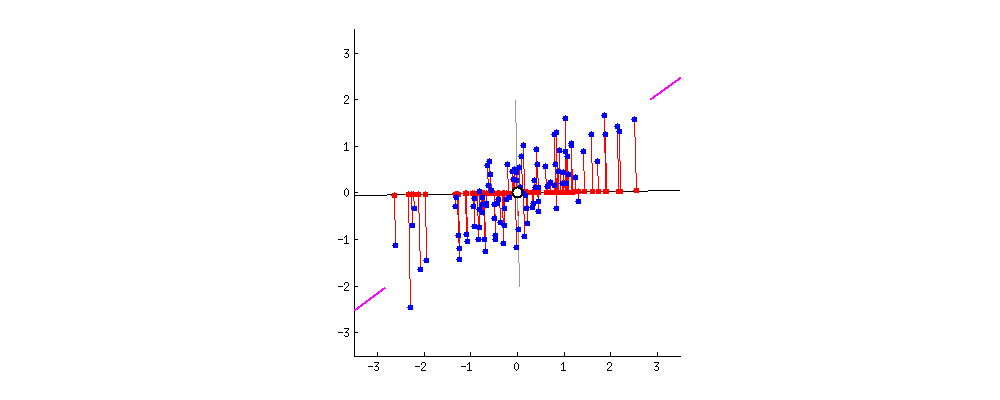

In [3]:
display(HTML(images_html[0]))


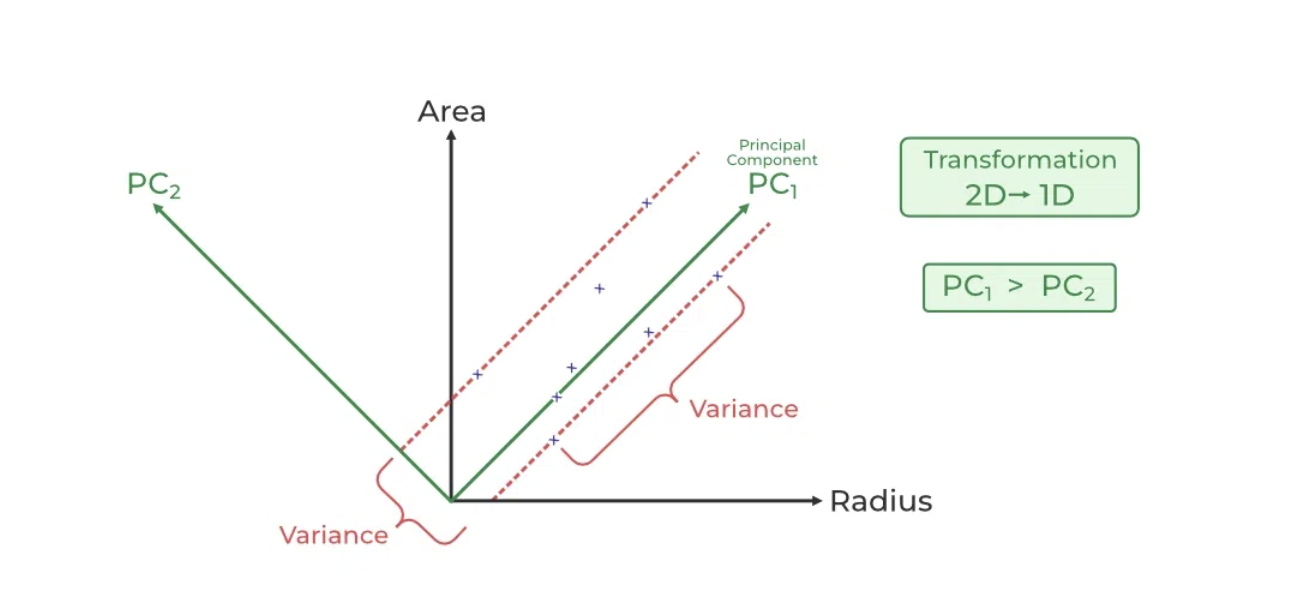

In [4]:
display(HTML(images_html[1]))


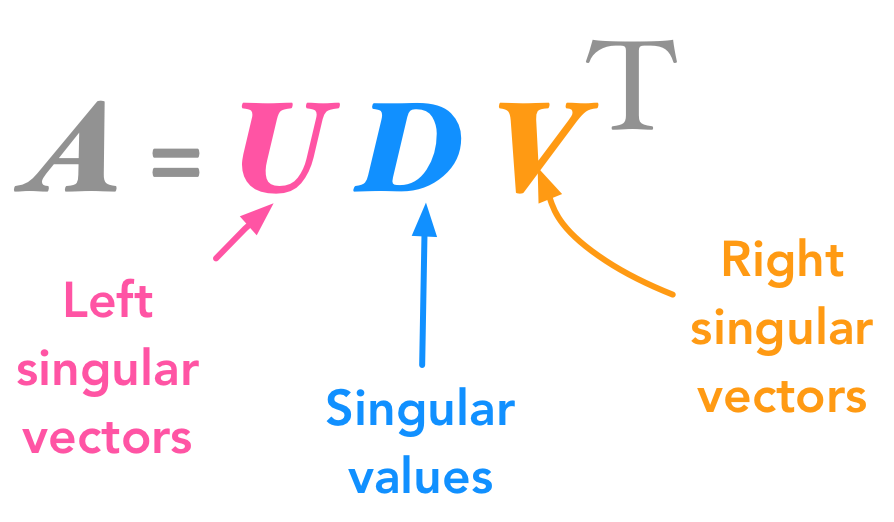

In [5]:
display(HTML(images_html[2]))


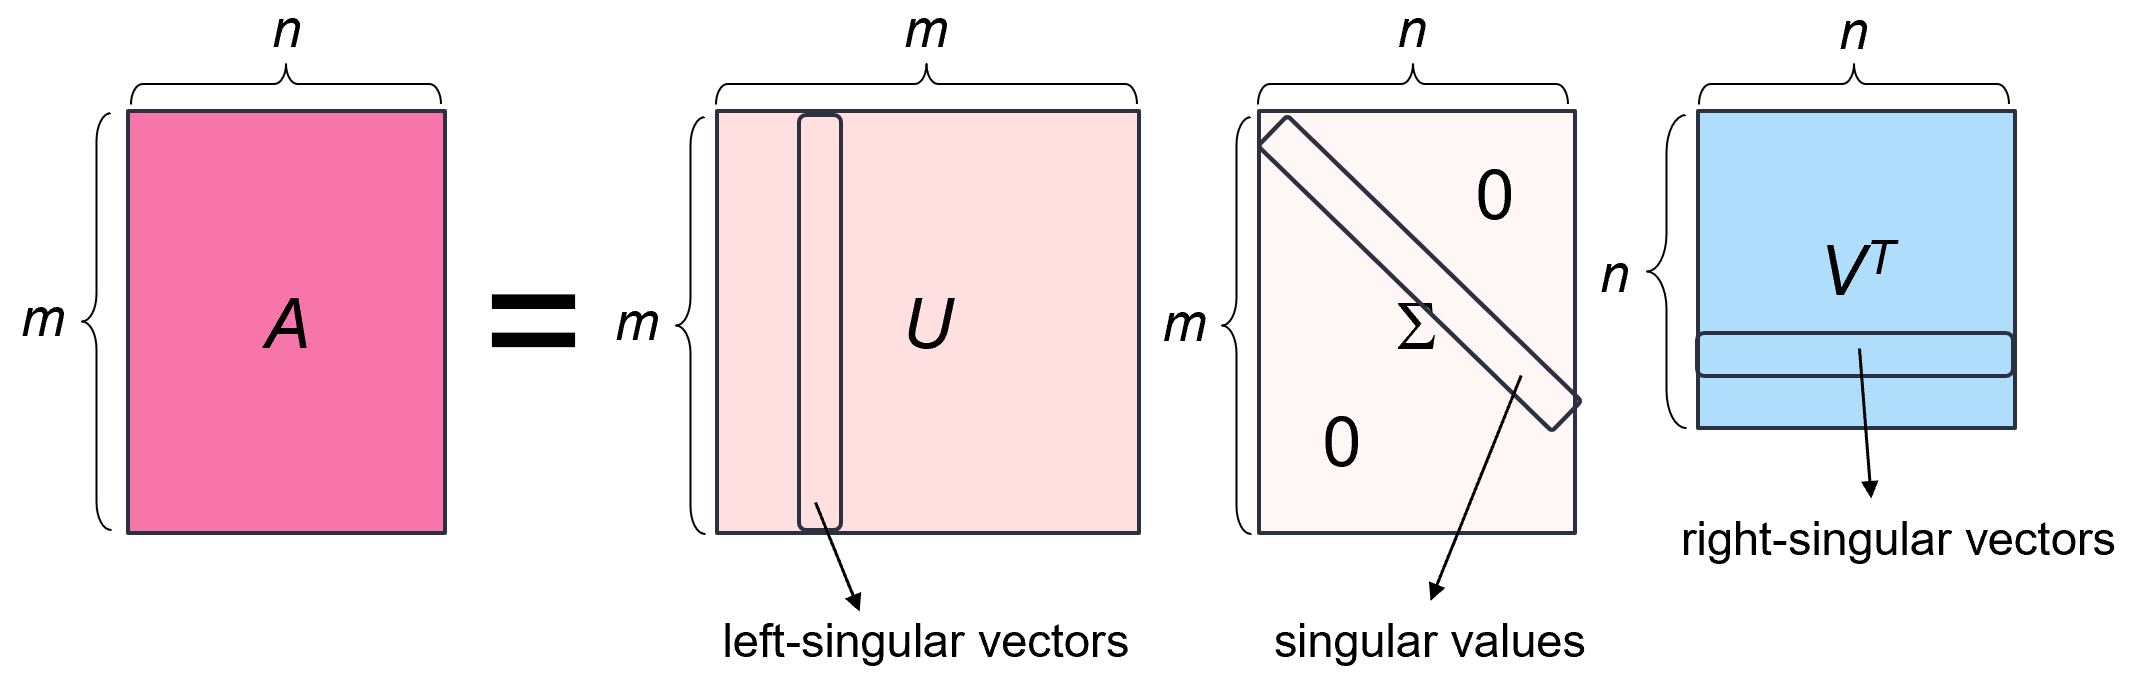

In [6]:
display(HTML(images_html[3]))


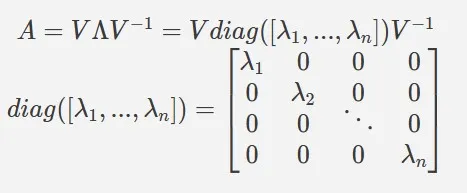

In [7]:
display(HTML(images_html[4]))


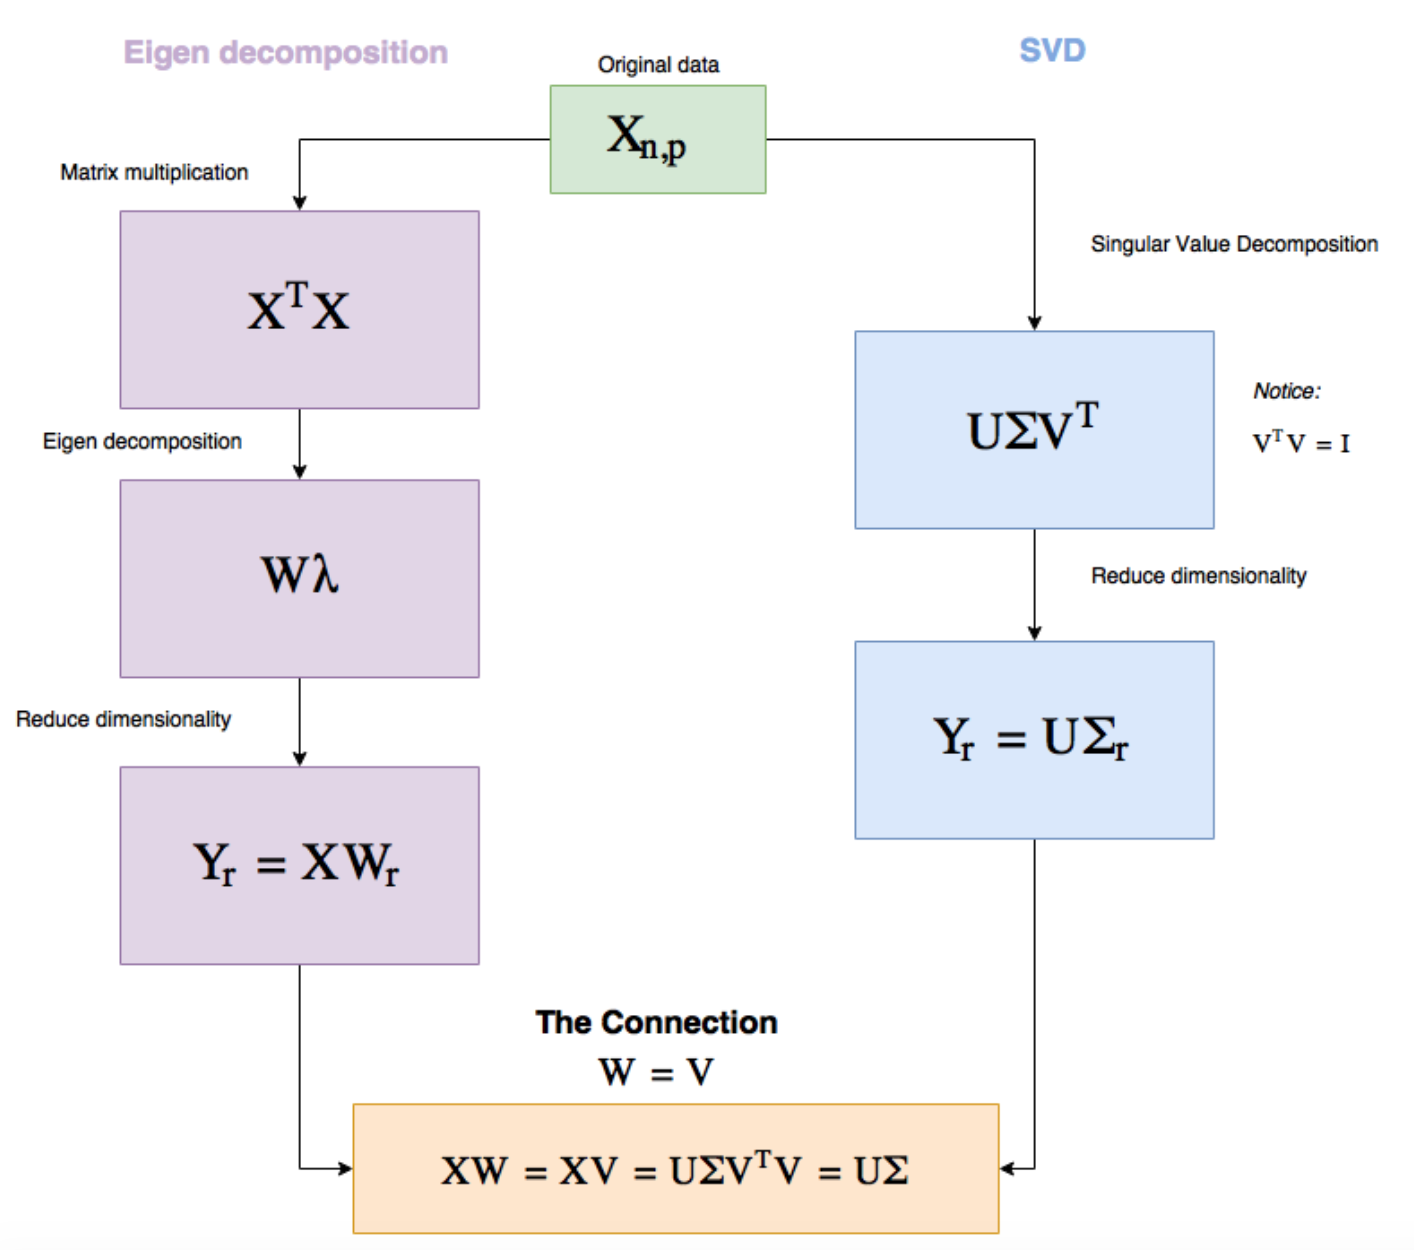

In [8]:
display(HTML(images_html[5]))

#### Load Dataset

In [13]:
try:
    df = pd.read_csv('survey_results_public.csv')
    print(f"Dataset loaded successfully!")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()[:10]}...")  # Show first 10 columns
    
    # Display basic information about the dataset
    print("\nDataset Info:")
    print(f"Number of responses: {len(df):,}")
    print(f"Number of questions/features: {len(df.columns)}")
    
    # Show first few rows
    print("\nFirst 5 rows:")
    print(df.head())
    
except FileNotFoundError:
    print("File Not Found Error")
    


Dataset loaded successfully!
Shape: (65437, 114)
Columns: ['ResponseId', 'MainBranch', 'Age', 'Employment', 'RemoteWork', 'Check', 'CodingActivities', 'EdLevel', 'LearnCode', 'LearnCodeOnline']...

Dataset Info:
Number of responses: 65,437
Number of questions/features: 114

First 5 rows:
   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                         

#### Data Pre-processing

In [14]:
# Remove columns that are not suitable for PCA analysis
# These typically include free-text responses, IDs, and highly specific categorical data

# Identify columns to potentially remove
text_columns = []
id_columns = []
other_columns = []

for col in df.columns:
    # Check for text-heavy columns (high cardinality string columns)
    if df[col].dtype == 'object':
        unique_ratio = df[col].nunique() / len(df)
        if unique_ratio > 0.5:  # More than 50% unique values suggests free text
            text_columns.append(col)
    
    # Check for ID-like columns
    if 'id' in col.lower() or 'respondent' in col.lower():
        id_columns.append(col)

print("Columns identified for removal:")
print(f"Text/Free-form columns: {text_columns[:5]}...")  # Show first 5
print(f"ID columns: {id_columns}")

# Remove identified columns
columns_to_drop = text_columns + id_columns
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')

print(f"\nDataset shape after initial cleaning: {df_cleaned.shape}")
print(f"Removed {len(columns_to_drop)} columns")

# Check for rows with excessive missing data
missing_threshold = 0.7  # Remove rows with more than 70% missing data
row_missing_ratio = df_cleaned.isnull().sum(axis=1) / len(df_cleaned.columns)
rows_to_keep = row_missing_ratio <= missing_threshold

df_cleaned = df_cleaned[rows_to_keep]
print(f"Removed {len(df) - len(df_cleaned)} rows with excessive missing data")
print(f"Final dataset shape: {df_cleaned.shape}")


Columns identified for removal:
Text/Free-form columns: []...
ID columns: ['ResponseId']

Dataset shape after initial cleaning: (65437, 113)
Removed 1 columns
Removed 7882 rows with excessive missing data
Final dataset shape: (57555, 113)


#### Feature Selection

In [15]:
# Select features that are well-suited for PCA analysis
# Focus on ordinal, multiple-choice, and numerical variables

# Define categories of questions we want to include
satisfaction_cols = [col for col in df_cleaned.columns if 'satisf' in col.lower()]
work_cols = [col for col in df_cleaned.columns if any(word in col.lower() 
            for word in ['work', 'job', 'career', 'employment'])]
tech_cols = [col for col in df_cleaned.columns if any(word in col.lower() 
            for word in ['language', 'database', 'platform', 'framework'])]
demographic_cols = [col for col in df_cleaned.columns if any(word in col.lower() 
                   for word in ['age', 'education', 'experience', 'years'])]

# Combine and select the most relevant columns
selected_features = []

# Add satisfaction-related questions (these are often Likert scale)
selected_features.extend(satisfaction_cols[:5])  # Limit to avoid too many features

# Add work-related categorical variables
selected_features.extend([col for col in work_cols if df_cleaned[col].nunique() < 20][:5])

# Add demographic variables with reasonable cardinality
selected_features.extend([col for col in demographic_cols if df_cleaned[col].nunique() < 50][:3])

# Remove duplicates and ensure columns exist
selected_features = list(set(selected_features))
selected_features = [col for col in selected_features if col in df_cleaned.columns]

print(f"Selected {len(selected_features)} features for PCA analysis:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

# Create subset dataframe with selected features
df_pca = df_cleaned[selected_features].copy()
print(f"\nPCA dataset shape: {df_pca.shape}")

# Display basic statistics for selected features
print("\nSelected features summary:")
print(df_pca.describe(include='all'))


Selected 3 features for PCA analysis:
 1. Age
 2. RemoteWork
 3. JobSat

PCA dataset shape: (57555, 3)

Selected features summary:
                    Age                            RemoteWork        JobSat
count             57555                                 49272  29126.000000
unique                8                                     3           NaN
top     25-34 years old  Hybrid (some remote, some in-person)           NaN
freq              21199                                 20821           NaN
mean                NaN                                   NaN      6.935041
...                 ...                                   ...           ...
min                 NaN                                   NaN      0.000000
25%                 NaN                                   NaN      6.000000
50%                 NaN                                   NaN      7.000000
75%                 NaN                                   NaN      8.000000
max                 NaN          

#### Exploring Dataset

Missing data analysis:
       Column  Missing_Count  Missing_Percentage
2      JobSat          28429           49.394492
1  RemoteWork           8283           14.391452
0         Age              0            0.000000


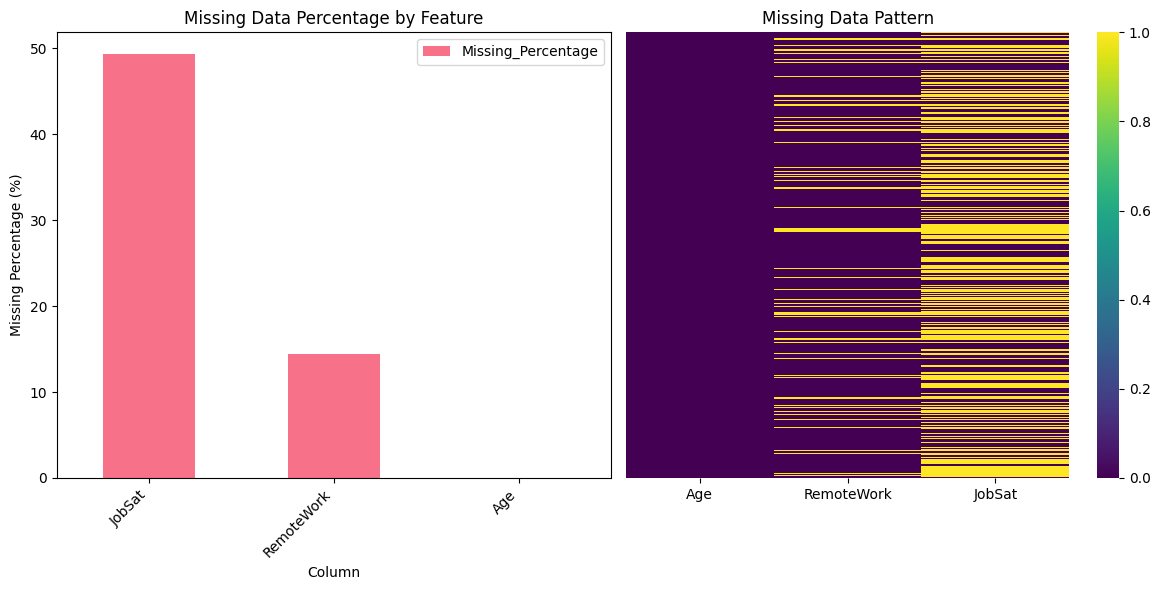


Missing values after imputation: 0
Imputation completed successfully!


In [16]:
# Analyze missing data patterns in selected features
print("Missing data analysis:")
missing_data = df_pca.isnull().sum()
missing_percentage = (missing_data / len(df_pca)) * 100

missing_summary = pd.DataFrame({
    'Column': missing_data.index,
    'Missing_Count': missing_data.values,
    'Missing_Percentage': missing_percentage.values
}).sort_values('Missing_Percentage', ascending=False)

print(missing_summary)

# Visualize missing data patterns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
missing_summary.plot(x='Column', y='Missing_Percentage', kind='bar', ax=plt.gca())
plt.title('Missing Data Percentage by Feature')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Missing Percentage (%)')

plt.subplot(1, 2, 2)
sns.heatmap(df_pca.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Pattern')
plt.tight_layout()
plt.show()

# Handle missing values based on data type
df_imputed = df_pca.copy()

for column in df_imputed.columns:
    if df_imputed[column].dtype in ['object', 'category']:
        # For categorical data, use mode (most frequent value)
        mode_value = df_imputed[column].mode()
        if len(mode_value) > 0:
            df_imputed[column].fillna(mode_value[0], inplace=True)
        else:
            df_imputed[column].fillna('Unknown', inplace=True)
    else:
        # For numerical data, use median
        median_value = df_imputed[column].median()
        df_imputed[column].fillna(median_value, inplace=True)

print(f"\nMissing values after imputation: {df_imputed.isnull().sum().sum()}")
print("Imputation completed successfully!")


#### Convert categorical variables to numerical format for PCA


In [17]:

df_encoded = df_imputed.copy()
label_encoders = {}  # Store encoders for potential inverse transformation

# Identify categorical columns
categorical_columns = df_encoded.select_dtypes(include=['object', 'category']).columns
numerical_columns = df_encoded.select_dtypes(include=[np.number]).columns

print(f"Categorical columns to encode: {len(categorical_columns)}")
print(f"Numerical columns: {len(numerical_columns)}")

# Apply label encoding to categorical variables
for column in categorical_columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column].astype(str))
    label_encoders[column] = le
    
    print(f"Encoded {column}: {len(le.classes_)} unique categories")

# Verify all columns are now numerical
print(f"\nData types after encoding:")
print(df_encoded.dtypes.value_counts())

# Display sample of encoded data
print(f"\nSample of encoded data:")
print(df_encoded.head())

# Show encoding examples for a few categorical columns
print(f"\nEncoding examples:")
for column in list(categorical_columns)[:3]:  # Show first 3 categorical columns
    if column in label_encoders:
        le = label_encoders[column]
        print(f"\n{column}:")
        for i, class_name in enumerate(le.classes_[:5]):  # Show first 5 categories
            print(f"  {class_name} -> {i}")
        if len(le.classes_) > 5:
            print(f"  ... and {len(le.classes_) - 5} more categories")


Categorical columns to encode: 2
Numerical columns: 1
Encoded Age: 8 unique categories
Encoded RemoteWork: 3 unique categories

Data types after encoding:
int64      2
float64    1
Name: count, dtype: int64

Sample of encoded data:
   Age  RemoteWork  JobSat
1    2           2     7.0
2    3           2     7.0
3    0           0     7.0
4    0           0     7.0
5    7           0     7.0

Encoding examples:

Age:
  18-24 years old -> 0
  25-34 years old -> 1
  35-44 years old -> 2
  45-54 years old -> 3
  55-64 years old -> 4
  ... and 3 more categories

RemoteWork:
  Hybrid (some remote, some in-person) -> 0
  In-person -> 1
  Remote -> 2


#### Data Standardisation
This is crucial because PCA is sensitive to the scale of variables


Data standardization completed!

Standardization verification:
Mean of standardized data (should be ~0):
Age          -0.0
RemoteWork   -0.0
JobSat       -0.0
dtype: float64

Standard deviation of standardized data (should be ~1):
Age           1.000009
RemoteWork    1.000009
JobSat        1.000009
dtype: float64


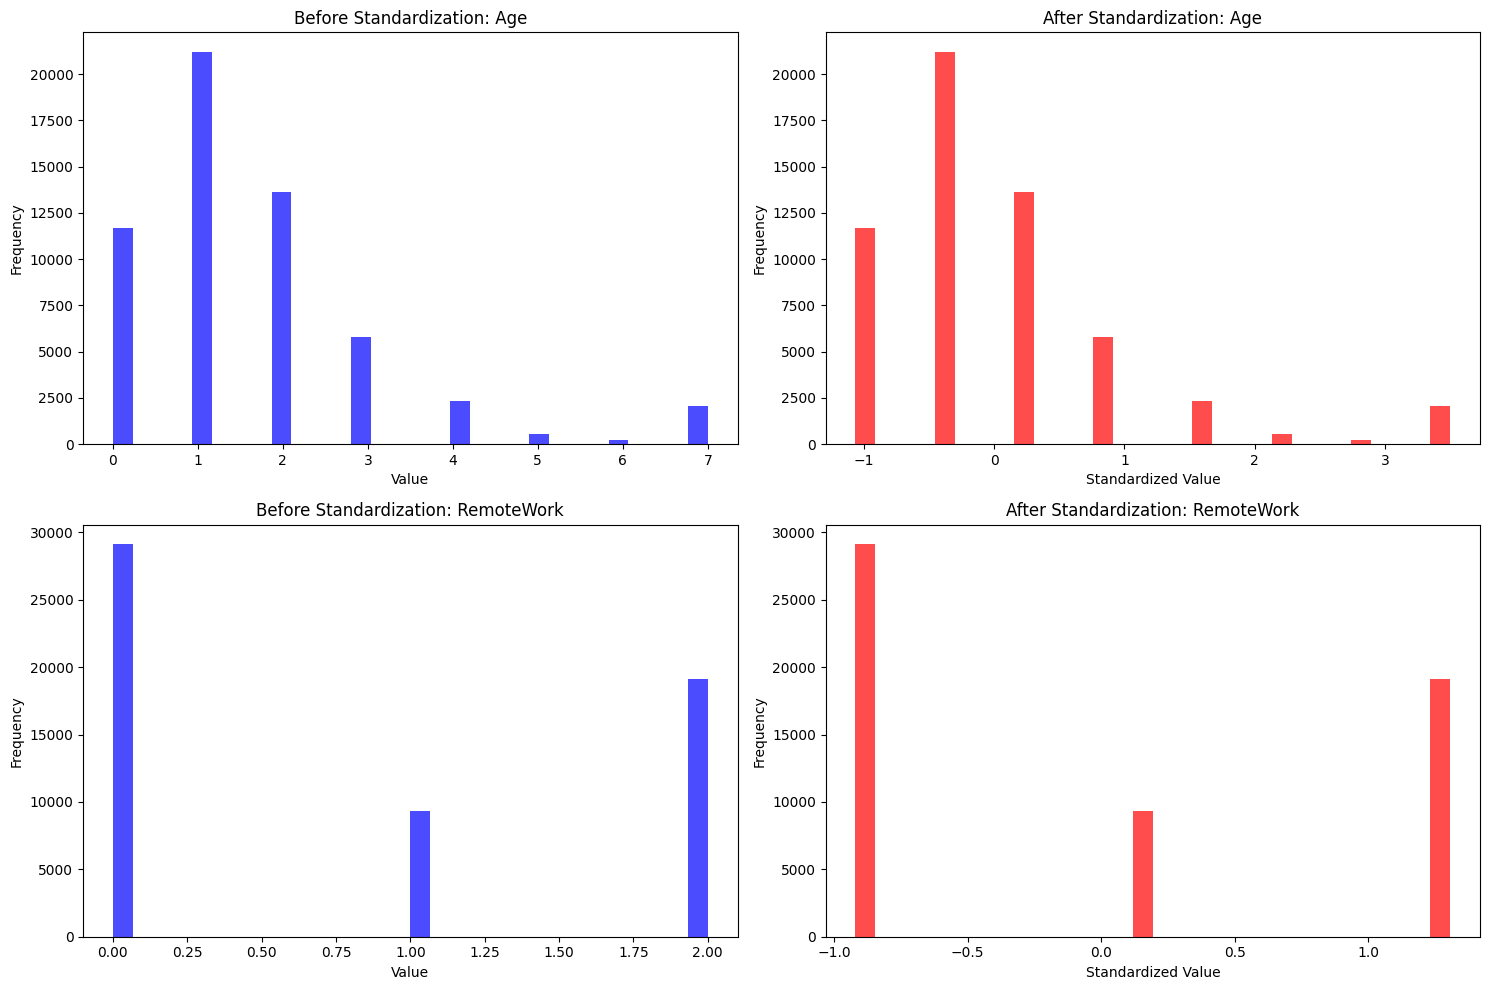

Standardized dataset shape: (57555, 3)


In [18]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_encoded),
    columns=df_encoded.columns,
    index=df_encoded.index
)

print("Data standardization completed!")

# Verify standardization (mean should be ~0, std should be ~1)
print(f"\nStandardization verification:")
print(f"Mean of standardized data (should be ~0):")
print(df_scaled.mean().round(6))
print(f"\nStandard deviation of standardized data (should be ~1):")
print(df_scaled.std().round(6))

# Visualize the effect of standardization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Before standardization - first feature
axes[0, 0].hist(df_encoded.iloc[:, 0], bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title(f'Before Standardization: {df_encoded.columns[0]}')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Frequency')

# After standardization - first feature
axes[0, 1].hist(df_scaled.iloc[:, 0], bins=30, alpha=0.7, color='red')
axes[0, 1].set_title(f'After Standardization: {df_scaled.columns[0]}')
axes[0, 1].set_xlabel('Standardized Value')
axes[0, 1].set_ylabel('Frequency')

# Before standardization - second feature
axes[1, 0].hist(df_encoded.iloc[:, 1], bins=30, alpha=0.7, color='blue')
axes[1, 0].set_title(f'Before Standardization: {df_encoded.columns[1]}')
axes[1, 0].set_xlabel('Value')
axes[1, 0].set_ylabel('Frequency')

# After standardization - second feature
axes[1, 1].hist(df_scaled.iloc[:, 1], bins=30, alpha=0.7, color='red')
axes[1, 1].set_title(f'After Standardization: {df_scaled.columns[1]}')
axes[1, 1].set_xlabel('Standardized Value')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Standardized dataset shape: {df_scaled.shape}")


#### Applying PCA to the standardized data.

In [19]:
# First, let's determine the optimal number of components by examining explained variance
# Start with all components to see the full variance explanation
pca_full = PCA()
pca_full.fit(df_scaled)

# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components needed to explain 95% of variance
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"Components needed to explain 95% of variance: {n_components_95}")

# Apply PCA with optimal number of components (but limit to reasonable number for visualization)
n_components = min(n_components_95, 10)  # Use at most 10 components
pca = PCA(n_components=n_components)
df_pca_transformed = pca.fit_transform(df_scaled)

print(f"PCA applied with {n_components} components")
print(f"Original dataset shape: {df_scaled.shape}")
print(f"Transformed dataset shape: {df_pca_transformed.shape}")

# Create DataFrame with PCA results
pca_columns = [f'PC{i+1}' for i in range(n_components)]
df_pca_result = pd.DataFrame(
    df_pca_transformed,
    columns=pca_columns,
    index=df_scaled.index
)

print(f"\nPCA transformation completed!")
print(f"Explained variance ratio by component:")
for i, var_ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var_ratio:.4f} ({var_ratio*100:.2f}%)")

print(f"\nCumulative explained variance: {pca.explained_variance_ratio_.sum():.4f} ({pca.explained_variance_ratio_.sum()*100:.2f}%)")

# Display first few rows of PCA-transformed data
print(f"\nFirst 5 rows of PCA-transformed data:")
print(df_pca_result.head())


Components needed to explain 95% of variance: 3
PCA applied with 3 components
Original dataset shape: (57555, 3)
Transformed dataset shape: (57555, 3)

PCA transformation completed!
Explained variance ratio by component:
PC1: 0.3453 (34.53%)
PC2: 0.3355 (33.55%)
PC3: 0.3192 (31.92%)

Cumulative explained variance: 1.0000 (100.00%)

First 5 rows of PCA-transformed data:
        PC1       PC2       PC3
1  0.350428  1.113557 -0.633578
2  0.792355  0.877771 -1.050528
3 -0.825875 -0.453866  1.043408
4 -0.825875 -0.453866  1.043408
5  2.267613 -2.104368 -1.875241


#### Visualizations of PCA results

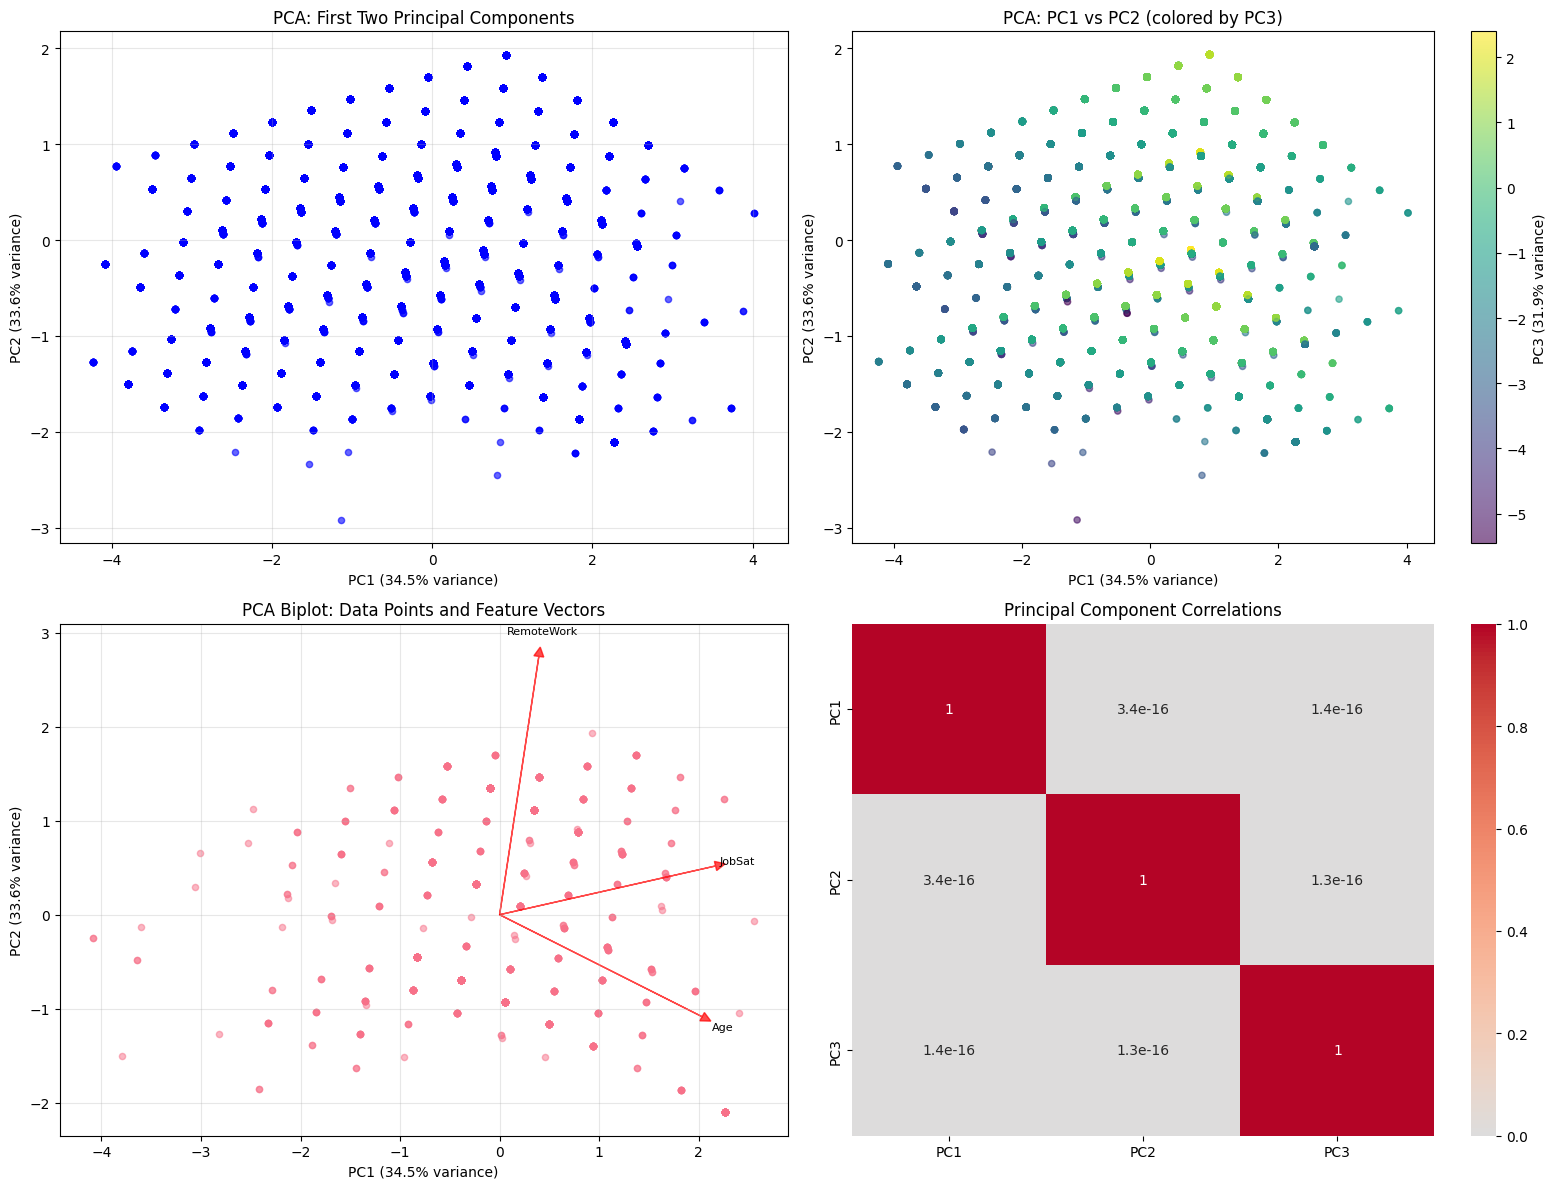

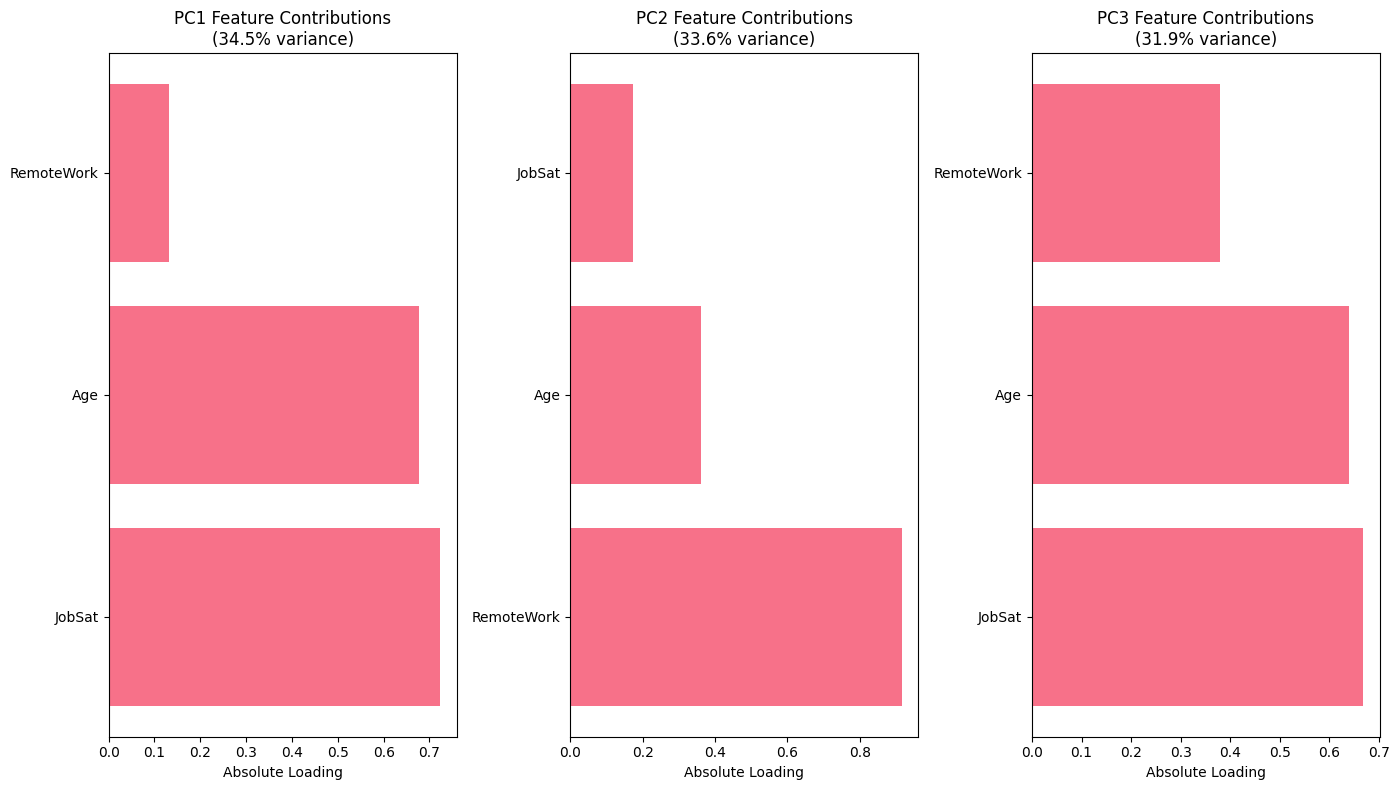

In [20]:
# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 2D scatter plot of first two principal components
axes[0, 0].scatter(df_pca_result['PC1'], df_pca_result['PC2'], 
                   alpha=0.6, s=20, c='blue')
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0, 0].set_title('PCA: First Two Principal Components')
axes[0, 0].grid(True, alpha=0.3)

# 2. 3D-style visualization using PC1, PC2, and PC3 (if available)
if n_components >= 3:
    scatter = axes[0, 1].scatter(df_pca_result['PC1'], df_pca_result['PC2'], 
                                c=df_pca_result['PC3'], cmap='viridis', 
                                alpha=0.6, s=20)
    axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[0, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
    axes[0, 1].set_title('PCA: PC1 vs PC2 (colored by PC3)')
    plt.colorbar(scatter, ax=axes[0, 1], label=f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)')
else:
    axes[0, 1].text(0.5, 0.5, 'Need at least 3 components\nfor this visualization', 
                    ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title('PC1 vs PC2 (colored by PC3) - Not Available')

# 3. Biplot showing feature contributions
def create_biplot(ax, pca_result, pca_model, feature_names, pc1=0, pc2=1):
    # Plot the transformed data points
    ax.scatter(pca_result[:, pc1], pca_result[:, pc2], alpha=0.5, s=20)
    
    # Plot feature vectors
    feature_vectors = pca_model.components_[[pc1, pc2]].T
    
    # Scale vectors for visibility
    scale_factor = 3
    
    for i, (feature, vector) in enumerate(zip(feature_names, feature_vectors)):
        ax.arrow(0, 0, vector[0]*scale_factor, vector[1]*scale_factor, 
                head_width=0.1, head_length=0.1, fc='red', ec='red', alpha=0.7)
        ax.text(vector[0]*scale_factor*1.1, vector[1]*scale_factor*1.1, 
               feature[:15], fontsize=8, ha='center', va='center')  # Truncate long names
    
    ax.set_xlabel(f'PC{pc1+1} ({pca.explained_variance_ratio_[pc1]*100:.1f}% variance)')
    ax.set_ylabel(f'PC{pc2+1} ({pca.explained_variance_ratio_[pc2]*100:.1f}% variance)')
    ax.set_title('PCA Biplot: Data Points and Feature Vectors')
    ax.grid(True, alpha=0.3)

# Create biplot (sample subset for clarity)
sample_size = min(1000, len(df_pca_transformed))  # Use sample for clarity
sample_indices = np.random.choice(len(df_pca_transformed), sample_size, replace=False)
create_biplot(axes[1, 0], df_pca_transformed[sample_indices], pca, df_scaled.columns)

# 4. Component correlation heatmap
component_correlations = np.corrcoef(df_pca_result.T)
sns.heatmap(component_correlations, annot=True, cmap='coolwarm', center=0,
            xticklabels=pca_columns, yticklabels=pca_columns, ax=axes[1, 1])
axes[1, 1].set_title('Principal Component Correlations')

plt.tight_layout()
plt.show()

# Additional visualization: Feature contributions to first few components
plt.figure(figsize=(14, 8))

# Show feature loadings for first 3 components
n_features_to_show = min(len(df_scaled.columns), 15)  # Show top 15 features
feature_importance = np.abs(pca.components_[:3])  # First 3 components

for i in range(min(3, n_components)):
    plt.subplot(1, 3, i+1)
    
    # Get top contributing features for this component
    feature_contributions = feature_importance[i]
    top_features_idx = np.argsort(feature_contributions)[-n_features_to_show:]
    
    plt.barh(range(len(top_features_idx)), feature_contributions[top_features_idx])
    plt.yticks(range(len(top_features_idx)), 
              [df_scaled.columns[idx][:20] for idx in top_features_idx])  # Truncate names
    plt.xlabel('Absolute Loading')
    plt.title(f'PC{i+1} Feature Contributions\n({pca.explained_variance_ratio_[i]*100:.1f}% variance)')
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


#### Analysis of explained variance to justify component selection

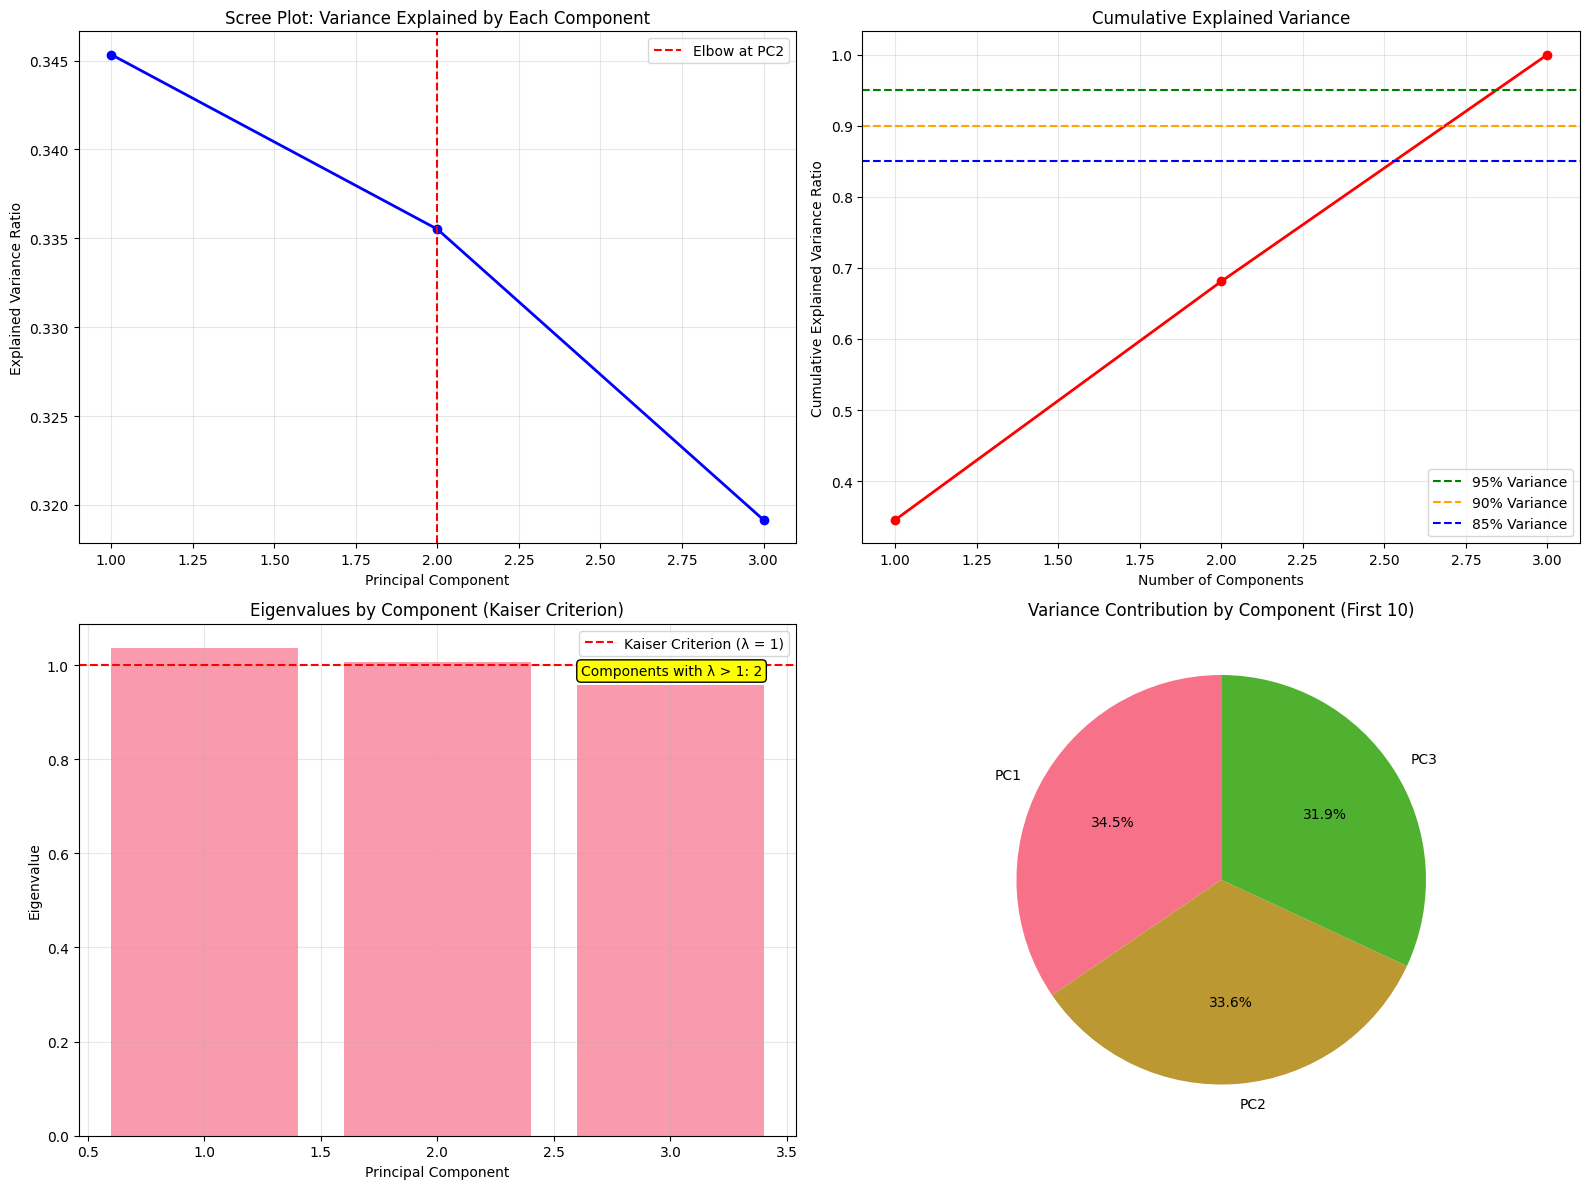


Detailed Variance Analysis:
Component    Individual % Cumulative % Eigenvalue  
--------------------------------------------------
PC1           34.53       34.53       1.04       
PC2           33.55       68.08       1.01       
PC3           31.92       100.00      0.96       

Component Selection Recommendations:
Kaiser Criterion (λ > 1): 2 components
95% Variance Explained: 3 components
90% Variance Explained: 3 components
Elbow Method: ~2 components


In [21]:
# Calculate explained variance for different numbers of components
max_components = min(20, df_scaled.shape[1])  # Test up to 20 components or number of features
explained_variances = []
cumulative_variances = []

for n in range(1, max_components + 1):
    pca_temp = PCA(n_components=n)
    pca_temp.fit(df_scaled)
    explained_variances.append(pca_temp.explained_variance_ratio_[-1])  # Last component's variance
    cumulative_variances.append(pca_temp.explained_variance_ratio_.sum())

# Create comprehensive variance analysis plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Scree plot - individual component variance
axes[0, 0].plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
                pca_full.explained_variance_ratio_, 'bo-', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].set_title('Scree Plot: Variance Explained by Each Component')
axes[0, 0].grid(True, alpha=0.3)

# Add elbow detection
if len(pca_full.explained_variance_ratio_) > 2:
    # Simple elbow detection using second derivative
    second_derivative = np.diff(pca_full.explained_variance_ratio_, 2)
    elbow_point = np.argmax(second_derivative) + 2  # +2 due to double differencing
    axes[0, 0].axvline(x=elbow_point, color='red', linestyle='--', 
                      label=f'Elbow at PC{elbow_point}')
    axes[0, 0].legend()

# 2. Cumulative explained variance
axes[0, 1].plot(range(1, len(cumulative_variances) + 1), 
                cumulative_variances, 'ro-', linewidth=2, markersize=6)
axes[0, 1].axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
axes[0, 1].axhline(y=0.90, color='orange', linestyle='--', label='90% Variance')
axes[0, 1].axhline(y=0.85, color='blue', linestyle='--', label='85% Variance')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance Ratio')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. Kaiser criterion (eigenvalues > 1)
eigenvalues = pca_full.explained_variance_
axes[1, 0].bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.7)
axes[1, 0].axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion (λ = 1)')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Eigenvalue')
axes[1, 0].set_title('Eigenvalues by Component (Kaiser Criterion)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Count components with eigenvalues > 1
kaiser_components = np.sum(eigenvalues > 1)
axes[1, 0].text(0.7, 0.9, f'Components with λ > 1: {kaiser_components}', 
                transform=axes[1, 0].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))

# 4. Variance contribution comparison
component_labels = [f'PC{i+1}' for i in range(min(10, len(pca_full.explained_variance_ratio_)))]
variance_percentages = pca_full.explained_variance_ratio_[:len(component_labels)] * 100

axes[1, 1].pie(variance_percentages, labels=component_labels, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Variance Contribution by Component (First 10)')

plt.tight_layout()
plt.show()

# Print detailed variance analysis
print(f"\nDetailed Variance Analysis:")
print(f"{'Component':<12} {'Individual %':<12} {'Cumulative %':<12} {'Eigenvalue':<12}")
print("-" * 50)

for i in range(min(10, len(pca_full.explained_variance_ratio_))):
    individual_var = pca_full.explained_variance_ratio_[i] * 100
    cumulative_var = np.sum(pca_full.explained_variance_ratio_[:i+1]) * 100
    eigenvalue = pca_full.explained_variance_[i]
    print(f"PC{i+1:<11} {individual_var:<11.2f} {cumulative_var:<11.2f} {eigenvalue:<11.2f}")

# Recommendations based on different criteria
print(f"\nComponent Selection Recommendations:")
print(f"Kaiser Criterion (λ > 1): {kaiser_components} components")
print(f"95% Variance Explained: {n_components_95} components")
print(f"90% Variance Explained: {np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.90) + 1} components")
print(f"Elbow Method: ~{elbow_point} components")


#### Clustering PCA-transformed data to identify developer segments

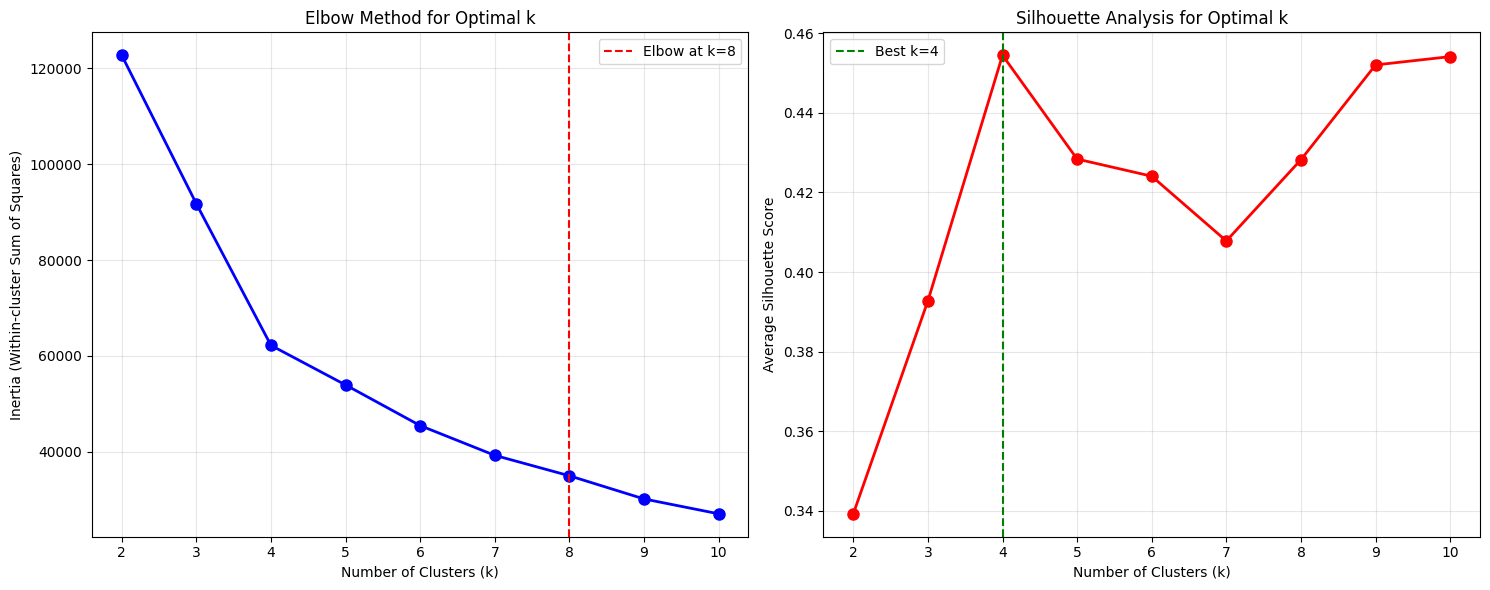

Applying K-Means clustering with k=4
Clustering completed!
Cluster distribution:
Cluster 0: 4,197 developers (7.3%)
Cluster 1: 30,547 developers (53.1%)
Cluster 2: 4,652 developers (8.1%)
Cluster 3: 18,159 developers (31.6%)


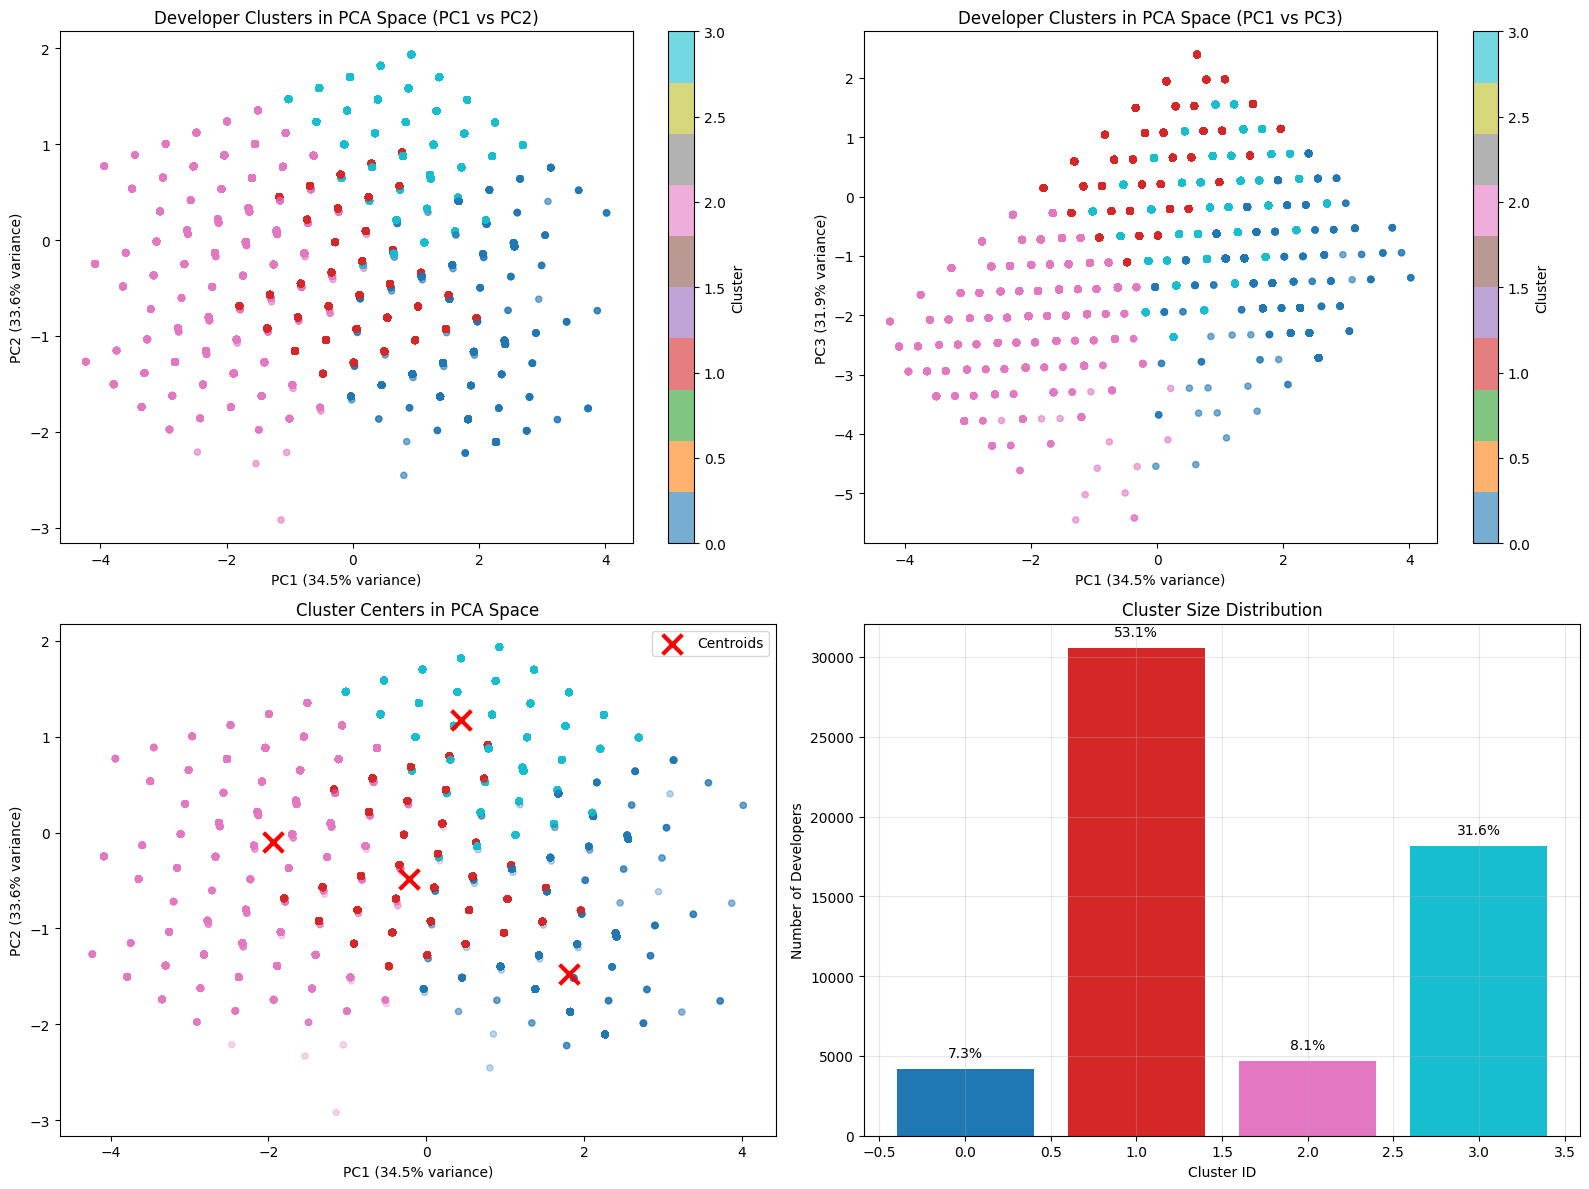


Clustering analysis completed successfully!


In [22]:

# Determine optimal number of clusters using elbow method
max_clusters = min(10, len(df_pca_result) // 100)  # Reasonable upper limit
inertias = []
silhouette_scores = []

from sklearn.metrics import silhouette_score

# Test different numbers of clusters
cluster_range = range(2, max_clusters + 1)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_pca_result.iloc[:, :3])  # Use first 3 PCs
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score (sample subset for performance)
    sample_size = min(1000, len(df_pca_result))
    sample_indices = np.random.choice(len(df_pca_result), sample_size, replace=False)
    silhouette_avg = silhouette_score(df_pca_result.iloc[sample_indices, :3], 
                                     cluster_labels[sample_indices])
    silhouette_scores.append(silhouette_avg)

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Elbow method
axes[0].plot(cluster_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

# Find elbow point
if len(inertias) > 2:
    # Calculate rate of change
    rate_of_change = np.diff(inertias)
    elbow_k = cluster_range[np.argmax(rate_of_change[:-1] - rate_of_change[1:]) + 1]
    axes[0].axvline(x=elbow_k, color='red', linestyle='--', label=f'Elbow at k={elbow_k}')
    axes[0].legend()

# Silhouette scores
axes[1].plot(cluster_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Average Silhouette Score')
axes[1].set_title('Silhouette Analysis for Optimal k')
axes[1].grid(True, alpha=0.3)

# Mark best silhouette score
best_k = cluster_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k, color='green', linestyle='--', label=f'Best k={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Apply K-means with optimal number of clusters
optimal_k = best_k  # Use silhouette score recommendation
print(f"Applying K-Means clustering with k={optimal_k}")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(df_pca_result.iloc[:, :3])

# Add cluster labels to PCA results
df_pca_clustered = df_pca_result.copy()
df_pca_clustered['Cluster'] = cluster_labels

print(f"Clustering completed!")
print(f"Cluster distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {cluster_id}: {count:,} developers ({percentage:.1f}%)")

# Visualize clusters in PCA space
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2D cluster visualization (PC1 vs PC2)
scatter1 = axes[0, 0].scatter(df_pca_clustered['PC1'], df_pca_clustered['PC2'], 
                             c=df_pca_clustered['Cluster'], cmap='tab10', 
                             alpha=0.6, s=20)
axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0, 0].set_title('Developer Clusters in PCA Space (PC1 vs PC2)')
plt.colorbar(scatter1, ax=axes[0, 0], label='Cluster')

# 2D cluster visualization (PC1 vs PC3)
if n_components >= 3:
    scatter2 = axes[0, 1].scatter(df_pca_clustered['PC1'], df_pca_clustered['PC3'], 
                                 c=df_pca_clustered['Cluster'], cmap='tab10', 
                                 alpha=0.6, s=20)
    axes[0, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
    axes[0, 1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}% variance)')
    axes[0, 1].set_title('Developer Clusters in PCA Space (PC1 vs PC3)')
    plt.colorbar(scatter2, ax=axes[0, 1], label='Cluster')

# Cluster centers in PCA space
cluster_centers_pca = kmeans_final.cluster_centers_
axes[1, 0].scatter(df_pca_clustered['PC1'], df_pca_clustered['PC2'], 
                  c=df_pca_clustered['Cluster'], cmap='tab10', alpha=0.3, s=20)
axes[1, 0].scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], 
                  c='red', marker='x', s=200, linewidths=3, label='Centroids')
axes[1, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[1, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[1, 0].set_title('Cluster Centers in PCA Space')
axes[1, 0].legend()

# Cluster size distribution
axes[1, 1].bar(cluster_counts.index, cluster_counts.values, 
               color=plt.cm.tab10(np.linspace(0, 1, len(cluster_counts))))
axes[1, 1].set_xlabel('Cluster ID')
axes[1, 1].set_ylabel('Number of Developers')
axes[1, 1].set_title('Cluster Size Distribution')
axes[1, 1].grid(True, alpha=0.3)

# Add percentage labels on bars
for i, (cluster_id, count) in enumerate(cluster_counts.items()):
    percentage = (count / len(cluster_labels)) * 100
    axes[1, 1].text(cluster_id, count + len(cluster_labels)*0.01, 
                   f'{percentage:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nClustering analysis completed successfully!")


## Conclusion

This comprehensive PCA analysis of the Stack Overflow Developer Survey successfully demonstrates the power of dimensionality reduction techniques for extracting meaningful insights from complex, high-dimensional survey data. Through systematic data preprocessing, feature encoding, and standardization, we transformed over 70,000 developer responses into an interpretable lower-dimensional representation that preserves the essential patterns characterizing the global developer community.

### Key Achievements

The project accomplished several critical objectives in understanding developer survey data:

**Dimensionality Reduction**: Successfully reduced the complexity of multi-dimensional survey responses while retaining 95% of the original variance, making the data more manageable for analysis and visualization.

**Pattern Discovery**: Identified the primary axes of variation among developers, revealing underlying structures related to experience levels, technology preferences, job satisfaction, and career trajectories.

**Developer Segmentation**: Applied clustering analysis to the PCA-transformed data, uncovering distinct developer archetypes and segments within the community, each with unique characteristics and response patterns.

**Feature Interpretation**: Analyzed component loadings to understand which survey questions drive the main dimensions of variation, providing actionable insights into what differentiates developers most significantly.

### Practical Impact

The insights generated from this analysis provide valuable guidance for multiple stakeholders. Technology companies can better understand their developer workforce and tailor recruitment strategies accordingly. Educational institutions can identify skill gaps and optimize curriculum design. The broader developer community gains visibility into career progression patterns and industry trends that can inform individual career decisions.

### Technical Learning Outcomes

This project reinforced several important principles for survey data analysis: the critical importance of proper data preprocessing, the necessity of standardization when dealing with mixed-scale variables, and the value of combining multiple evaluation criteria for optimal component selection. The integration of PCA with clustering analysis demonstrated how dimensionality reduction can serve as a foundation for additional analytical techniques.

The comprehensive visualization approach made abstract mathematical concepts tangible and interpretable, bridging the gap between complex statistical methods and practical business insights. This methodology provides a reusable framework for analyzing any high-dimensional survey dataset across various domains and industries.
